# Assignment 2 - Leonardo Stoppani

# Image Classification with Convolutional Neural Networks on CIFAR-10

## Define and train the model 

For this assignment i choose to use the `keras` library since it offers a straightforward API to build and train CNNs.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from pprint import pprint


### Data preparation

First the dataset is loaded from keras datasets with the `load_data()` function. Then train data are splitted into training and validation with `sklearn` function `train_test_split()`. From this point only training and validation data will be used to train the model, test data will be used only to evaluate the final model and give an accuracy score.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

print(X_train.shape, X_val.shape, X_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


Labels are converted to one-hot encoding with `keras.utils.to_categorical()` to exploit the distribution learning capabilities of the model. Also images are normalized to have values between 0 and 1.

In [4]:
# one hot encode target values
train_labels = to_categorical(y_train, num_classes=10)
val_labels = to_categorical(y_val, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)

# normalize pixel values
train_images = X_train.astype('float32') / 255
val_images = X_val.astype('float32') / 255
test_images = X_test.astype('float32') / 255

Just a look to the dataset.

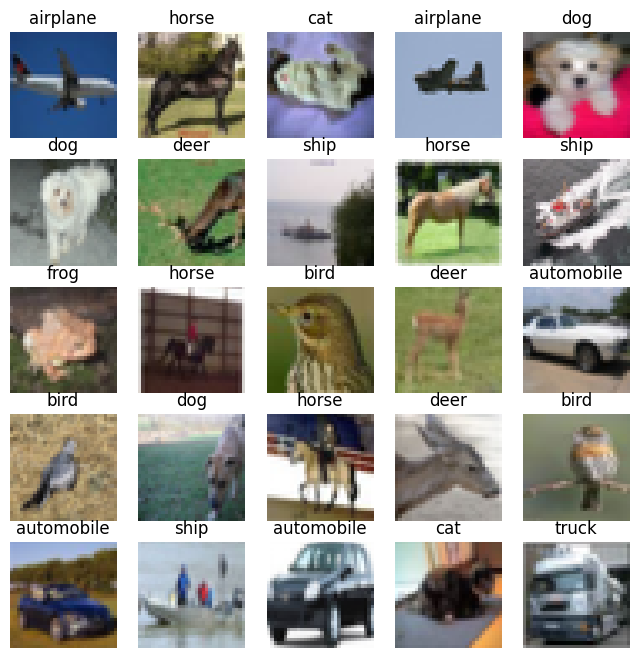

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                'horse', 'ship', 'truck']

fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(train_images[i])
    # show labels from one hot to categorical
    ax.set_title(class_names[np.argmax(train_labels[i])])
    ax.axis('off')
plt.show()


### Data augmentation
To achieve better results, data augmentation is performed using the keras class `ImageDataGenerator` which apply random transformations to the images. This will allow the model to generalize better, and to be more robust to different transformations of the input images, working as regularization.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(train_images)

### Define the CNN architecture
The model architecture is made of 3 convolutional layers with 32, 64 and 128 filters respectively, followed by a fully connected layer with 256 units and a softmax output layer with 10 units. The convolutional layers use a 3x3 kernel and a stride of 1, the activation function used is ReLU and the max pooling is performed with a 2x2 kernel and a stride of 2. To regularize the model, dropout is applied after each convolutional layer and after the fully connected layer. 

Different architectures have been tested, but this one had the best tradeoff between accuracy and complexity. State of the art results on CIFAR-10 are achieved with more parameters, usually 5 convolutional layers are used, with more filters and a larger fully connected layer. I try to keep the number of parameters contained to reduce the time of training, in order to perform more experiments. In this way i could also focus on the choose of hyperparameters to achieve good results.

Dropout and data augmentation were key factors to avoid overfitting and keep the training and validation accuracy close until the end of the training. Without these techniques, the model was overfitting and could not achieve more than 77% accuracy in validation.

The final model has 620.362 parameters, it takes about 20 minutes to train on a GPU and is able to reach 83% accuracy on the test set.

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)         

### Train the model
The model is trained for 100 epochs, with a batch size of 128, using the Adam optimizer with a learning rate of 0.001. The loss function used is categorical crossentropy, and the metric used to evaluate the model is accuracy. After training the model for 100 epochs the model was not overfitting so i decide to continue training for 50 more epochs. Early Stopping halt the training after 130 epochs, when the validation loss stopped improving.

Adam optimizer is used with default parameters. The learning rate is set to 0.001, it is a good value for Adam, and it is not too high to cause the model to diverge. The learning curve is a bit noisy, but make sense with Adam, because it is able to adapt the learning rate for each parameter, so it is normal to see some spikes in the loss curve.

The following cell are commented because the model is already trained and saved, so it is not necessary to train it again.

In [53]:
adam = keras.optimizers.legacy.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

#model.compile(optimizer=adam,
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=['accuracy'])

In [54]:
tf.device('/device:GPU:0')

early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True, mode='min')

# tensorboard callback
! rm -rf ./logs/
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

#history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=100,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True, mode='min')

# history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
#                    epochs=50,
#                    validation_data=(val_images, val_labels),
#                    callbacks=[early_stopping, tensorboard_callback])


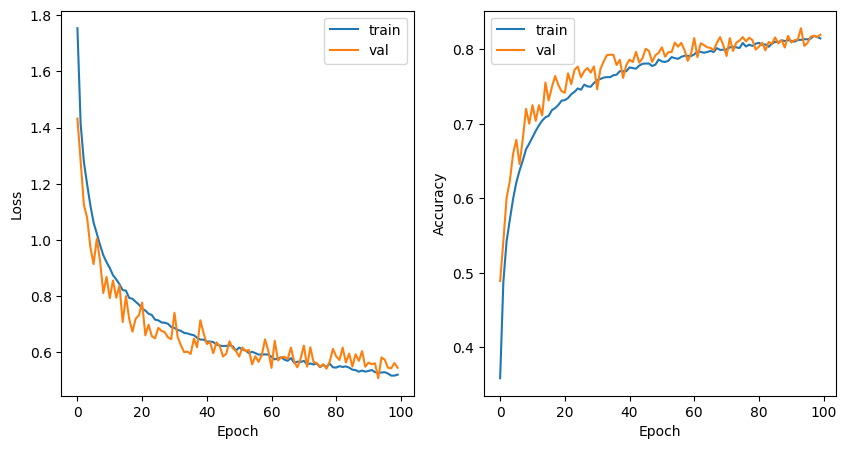

In [57]:
# plot loss and accuracy of validation and training data in subplots
#plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend()
#plt.subplot(1,2,2)
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

from IPython.display import Image
Image(filename='lc.png')

In [ ]:
# save the model with unique name based on number of parameters and validation accuracy
#model.save(f'cifar10_model_{model.count_params()}_{round(history.history["val_accuracy"][-1], 2)}.h5')

### Evaluate model on test set
Evaluating the model on test images shows an accuracy of 83,23%.

In [13]:
model = models.load_model('cifar10_model_620362_0.83.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc*100:.2f}%')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-11 19:03:14.803323: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 - 3s - loss: 0.5198 - accuracy: 0.8323 - 3s/epoch - 8ms/step
Test accuracy: 83.23%


Confusion matrix shows that the model is able to classify most of the images correctly. However, it makes mistake on image wich represent similar category. An obvious case is the one of `Cat` and `Dog`, the number of dog predicted as cat is 123. Cat and dogs, truck and automobile, have similar features that causes misclassifications, a way to improve model performance could be to add the number of filter, so that the model can learn more complex features.

313/313 [==============================] - 1s 3ms/step


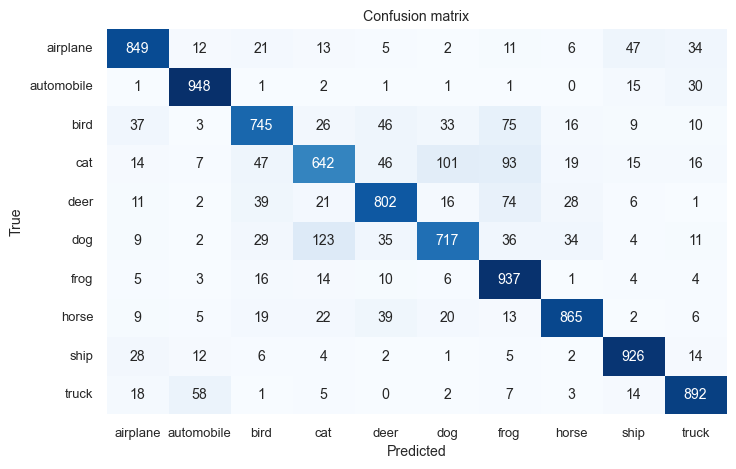

In [23]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,5))
# label size
sns.set(font_scale=0.85)
plt.tight_layout()
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The above image shows an example of dog misclassified as a dog.

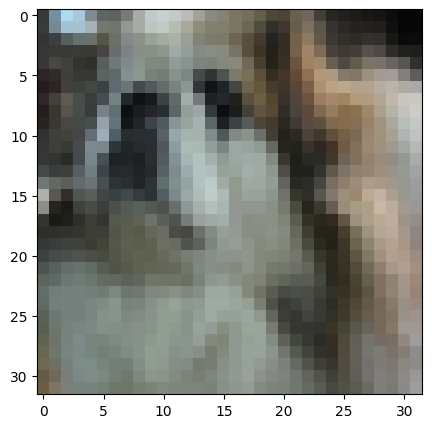

cat: 0.49747562408447266
dog: 0.4709009528160095
horse: 0.01591530069708824
bird: 0.007559230085462332
deer: 0.004406760912388563


In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(test_images[7258])
plt.show()

# predict class of random image
prediction = model.predict(test_images[7258].reshape(1, 32, 32, 3), verbose=0)

# ptint the first 5 class labels with highest probability
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

## Test with occlusions

Now that we have the final model, we can test it with occluded images. First we define a function `patch_image()` that take an image as input and return the same image with a gray patch of `nxn` size. The function allows also to specify the position of the patch with the `x` and `y` parameters. 

The idea is to look at the confusion matrix and choose the most confused classes, then occlude the images of the test set with a patch of different size and position, and see how the model perform on these images.

In [14]:
def patch_image(image, x=0, y=0, n=1):
    """
    Returns a copy of an image with a patch of size n x n at position x, y.
    
    Args:
        image: image to be patched
        x: x coordinate of patch
        y: y coordinate of patch
        n: size of patch
        
    Returns:
        image: patched image
    """
    im = image.copy()
    im[x:x+n, y:y+n] = 0.5
    return im

Start by taking a random image of a cat and appply a patch of 10x10 size. The probability of predicted label to be cat drops significally from 0.83 to 0.67. On the image with the patch the model is still able to recognize the cat, but with a lower probability and is more confused with dog.

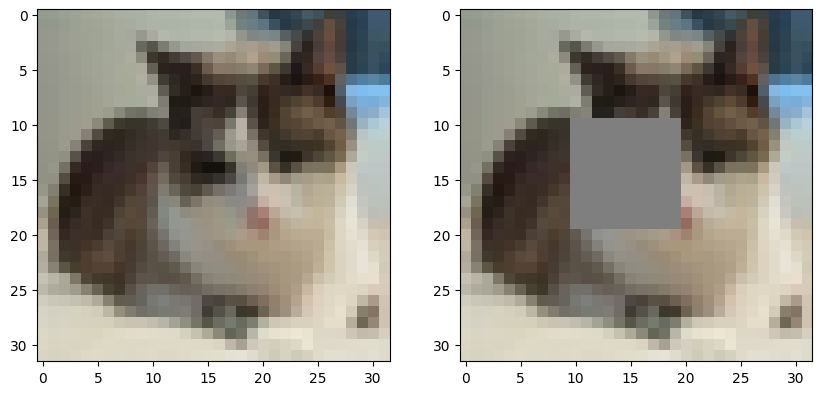

In [15]:
gatto = 3129
patch_image1 = patch_image(test_images[gatto], 10, 10, 10)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_images[3129])
plt.subplot(1, 2, 2)
plt.imshow(patch_image1)
plt.show()

In [19]:
prediction = model.predict(test_images[gatto].reshape(1, 32, 32, 3), verbose=0)
print('Prediction on original image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

Prediction on original image:
cat: 0.8310598134994507
dog: 0.16566582024097443
frog: 0.0021836585365235806
deer: 0.0005938632530160248
bird: 0.000213820138014853


In [20]:
prediction = model.predict(patch_image1.reshape(1, 32, 32, 3), verbose=0)
print('Prediction on patched image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

Prediction on patched image:
cat: 0.669676661491394
dog: 0.29367831349372864
bird: 0.009415562264621258
truck: 0.008858528919517994
frog: 0.006101746577769518


Model has also problem to distinguish between `Automobile` and `Truck`. The following image is classified correctly as a truck with a probability of 0.99, applying a patch of 15x15 size in the bottom right corner causes the model to misclassify the image as automobile with a probability of 0.64. The applied patch cover the tires, which are a key features of both classes so probably this means that the model use the dimensions of the tires to classify the image as truck. 

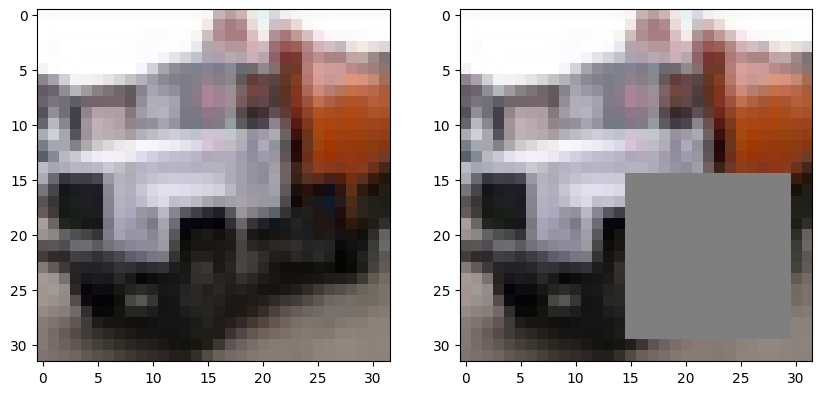

In [13]:
truck = 3409
patch_image2 = patch_image(test_images[3409], 15, 15, 15)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_images[truck])
plt.subplot(1, 2, 2)
plt.imshow(patch_image2)
plt.show()

In [24]:
prediction = model.predict(test_images[truck].reshape(1, 32, 32, 3), verbose=0)
print('Prediction on original image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

Prediction on original image:
truck: 0.9997172951698303
automobile: 0.00028261059196665883
airplane: 5.8283873727305036e-08
ship: 1.4037413897938222e-08
dog: 7.57996443390141e-11


In [25]:
prediction = model.predict(patch_image2.reshape(1, 32, 32, 3))
print('Prediction on patched image:')
for i in range(5):
    print(f'{class_names[np.argsort(prediction[0])[-i-1]]}: {prediction[0][np.argsort(prediction[0])[-i-1]]}')

1/1 [==============================] - 0s 22ms/step
Prediction on patched image:
automobile: 0.6405659317970276
truck: 0.3130090832710266
airplane: 0.04376723989844322
ship: 0.0021947561763226986
horse: 0.00020000821677967906


### Accuracy on occluded images

After the first test we can now check how much the accuracy on test set drops when we occlude part of the image. The following function `occlusion_accuracy()` takes as input the model, the images, the labels and a list of patch sizes, and return a dict with accuracies for every patch size. 

In [16]:
def occlusion_accuracy(model, images, labels, sizes):
    """
    Returns the accuracy of a model on occluded images.

    Args:
        model: trained model
        images: images to be occluded
        labels: labels of the images
        sizes: list of sizes of the patch

    Returns:
        acc_size: dictionary of accuracies for each patch size

    """
    acc_size = {}
    for size in sizes:
        patched_images = []
        for i in range(len(images)):
            patched_images.append(patch_image(images[i], 5, 5, size))

        patched_images = np.array(patched_images)

        test_loss, test_acc = model.evaluate(patched_images, labels, verbose=0)

        acc_size[size] = test_acc

    return acc_size
    

As we can expect the accuracy of the model drops as the patch size increases. The model is able to classify correctly images with a patch of 5x5 size with an accuracy of 0.83, but when the patch size is 15x15 the accuracy drops to 0.67. It seems that patch of size lower than 5x5 do not affect so much the model performance. When the patch became nearly the dimension of the image, the model is not able to recognize the object anymore and the accuracy drops to 0.1.

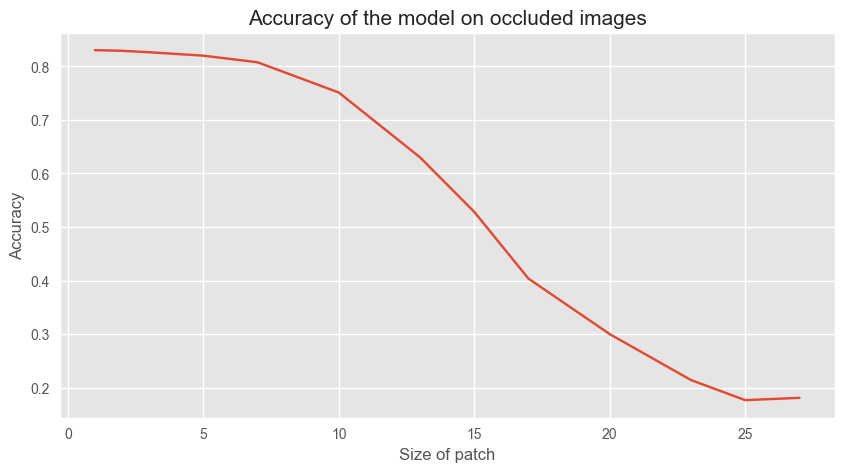

In [37]:
acc_size = occlusion_accuracy(model, test_images, test_labels, [1, 2, 3, 5, 7, 10, 13, 15, 17, 20, 23, 25, 27])

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(acc_size.keys(), acc_size.values())
plt.title('Accuracy of the model on occluded images', size=15)
plt.xlabel('Size of patch')
plt.ylabel('Accuracy')
plt.show()

### Find main pixels

By sliding a pacth of 1x1 over all the image we can also check which pixel is more important for the classification. The function `main_pixels()` takes as input the model, the image and the patch size, and return a dict with the probability of the predicted label for every position of the patch. To find the main pixel of the image we can call the function like this
```python
main_pixels(model, test_images[3129], 1)
```
and then take the pixel with the lowest probability of predicted label. 

In [8]:
def main_pixels(model, image, size):
    """
    Returns the pixel or patch that if occluded will result in the lowest probability of the correct class.

    Args:
        model: trained model
        image: image to be patched
        size: size of patch (1 is a pixel, 2 is a 2x2 patch, etc.)

    Returns:
        (x, y): coordinates of pixel/patch 
    """
    pix_prob = {}
    for j in range(32):
        for k in range(32):

            pp = patch_image(image, j, k, size)
            pp = pp.reshape(1, 32, 32, 3)

            prediction = model.predict(pp, verbose=0)
            prediction_prob = prediction[0][np.argsort(prediction[0])[-1]]
            prediction_name = class_names[np.argmax(prediction)]

            pix_prob[(j, k)] = (prediction_prob, prediction_name)
    
    return pix_prob

In the cat image the pixel with coordinates (14, 5) is the one that drop the most the prediction of the model. With only this pixel occluded the model turns from predict the class with 83% probability to 72%. The heatmap shows the most critical pixels for the classification, where darker pixels are the one that drop the most the probability of predicted label. The heatmap shows that most important pixels are the ones that represent cat ears, eyes and body.

In [ ]:
pix_prob = main_pixels(model,test_images[3129],1)

# pixel with lowest probability
main_pixel = min(pix_prob.items(), key=lambda x: x[1][0])
x,y = main_pixel[0]

((14, 5), (0.72262454, 'cat'))


<Axes: >

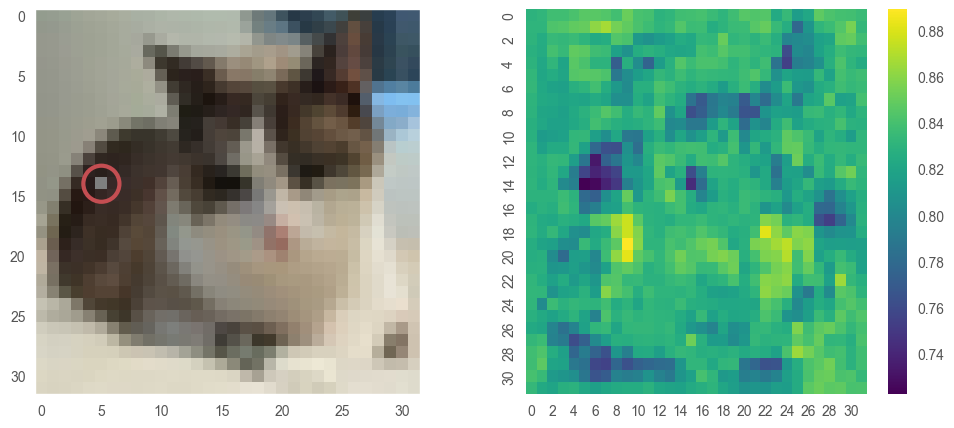

In [65]:
plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)
circle = plt.Circle((y, x), 1.5, color='r', fill=False, linewidth=3)
plt.gca().add_patch(circle)
plt.grid(False)
plt.imshow(patch_image(test_images[3129], x, y, 1))

pprint(main_pixel)

plt.subplot(1, 2, 2)
plt.subplots_adjust(right=2)
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_prob[(i, j)][0]
sns.heatmap(heatmap, cmap='viridis')

In [ ]:
# TODO: another class example

The function `acc_pixels()` takes as input the model, the images, the labels and the patch size, and return a dict with the accuracy of the model for every position of the patch. To find the most important pixel we can call the function like this:
```python
acc_pixels(model, test_images, test_labels, 1)
```


In [33]:
# for all pixel positions, compute the accuracy of the model on the occluded images
def acc_pixels(model, images, labels, size=1):
    """
    Returns the accuracy of the model on occluded images at each pixel.

    Args:
        model: trained model
        images: images to be occluded
        labels: labels of the images
        size: size of patch (1 is a pixel, 2 is a 2x2 patch, etc.)

    Returns:
        pix_acc: dictionary of accuracies for each pixel
    """
    pix_acc = {}
    for i in range(32):
        for j in range(32):
            # occlude all test images at pixel (i, j)
            patched_images = []
            for z in range(len(images)):
                patched_images.append(patch_image(images[z], i, j, size))

            patched_images = np.array(patched_images)
            test_loss, test_acc = model.evaluate(patched_images, labels, verbose=0)

            pix_acc[(i, j)] = test_acc
    
    return pix_acc

Due to the computational cost of the function, it is not possible to run it on all the images of the test set. The following cell run the function on 100 images from the test set, and then plot the heatmap of the most important pixels.

In [38]:
test_images_small = test_images[:100]
test_labels_small = test_labels[:100]

pix_acc = acc_pixels(model, test_images_small, test_labels_small, 1)

The heatmap shows that the most important pixels are the ones that represent the object, for example the wheels of the truck, the eyes of the cat, the body of the dog.

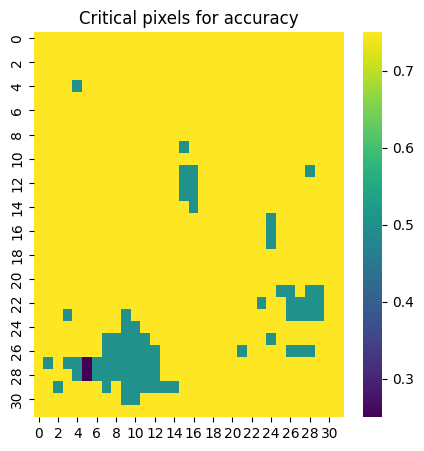

In [39]:
# plot heatmap of accuracies for each pixel
plt.figure(figsize=(5,5))
heatmap = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        heatmap[i, j] = pix_acc[(i, j)]
sns.heatmap(heatmap, cmap='viridis')
plt.title('Critical pixels for accuracy', size=12)
plt.show()


## Final Considerations
